In [30]:
%pip install matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import joblib
from load_and_preprocess import load_model_components, preprocess_data
import matplotlib.pyplot as plt

In [2]:
# Load model components
model_components = load_model_components('models/aussie_rain.joblib')
#joblib.dump(model, 'models/aussie_rain.joblib', compress=('zlib', 3))

In [3]:
# Load dataset
raw_df = pd.read_csv('data/weatherAUS.csv')

raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

In [4]:
raw_df.RainTomorrow.value_counts()

RainTomorrow
No     109586
Yes     31201
Name: count, dtype: int64

In [5]:
# Create train and test sets
X = raw_df[model_components['input_cols']]
y = raw_df[model_components['target_col']]
train_inputs, test_inputs, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# Check train dataset for null values
train_inputs.isna().sum().apply(lambda x: format(x/train_inputs.shape[0],'.2%'))

Location          0.00%
MinTemp           0.32%
MaxTemp           0.20%
Rainfall          0.00%
Evaporation      42.45%
Sunshine         47.55%
WindGustDir       6.51%
WindGustSpeed     6.47%
WindDir9am        6.85%
WindDir3pm        2.60%
WindSpeed9am      0.74%
WindSpeed3pm      1.79%
Humidity9am       1.07%
Humidity3pm       2.50%
Pressure9am       9.80%
Pressure3pm       9.83%
Cloud9am         37.38%
Cloud3pm         39.84%
Temp9am           0.45%
Temp3pm           1.87%
RainToday         0.00%
dtype: object

In [7]:
# Preprocess raw data with trained imputer, scaler, encoder
X_train, train_inputs = preprocess_data(train_inputs, model_components)
X_test, test_inputs = preprocess_data(test_inputs, model_components)

D:\04_work\programming\projects\streamlit_australia_rain\load_and_preprocess.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[components['encoded_cols']] = components['encoder'].transform(data[components['categorical_cols']])
D:\04_work\programming\projects\streamlit_australia_rain\load_and_preprocess.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[components['encoded_cols']] = components['encoder'].transform(data[components['categorical_cols']])
D:\04_work\programming\projects\streamlit_australia_rain\load_an

In [8]:
# Define and train Random Forest model
model = RandomForestClassifier(n_estimators=20, max_leaf_nodes=30,n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

# Make predictions on train set
pred_train = model.predict(X_train)
print(classification_report(y_train, pred_train, digits=4))

              precision    recall  f1-score   support

          No     0.8308    0.9822    0.9002     87668
         Yes     0.8260    0.2974    0.4373     24961

    accuracy                         0.8304    112629
   macro avg     0.8284    0.6398    0.6687    112629
weighted avg     0.8297    0.8304    0.7976    112629



In [9]:
# Make predictions on test set
pred_test = model.predict(X_test)
proba_test = model.predict_proba(X_test)[:,1]
print(classification_report(y_test, pred_test, digits=4))
auroc = roc_auc_score(y_test, proba_test)
print(f'AUROC = {auroc:.6f}')

              precision    recall  f1-score   support

          No     0.8322    0.9794    0.8998     21918
         Yes     0.8090    0.3061    0.4441      6240

    accuracy                         0.8302     28158
   macro avg     0.8206    0.6428    0.6720     28158
weighted avg     0.8270    0.8302    0.7988     28158

AUROC = 0.840059


In [10]:
from imblearn.over_sampling import RandomOverSampler

In [11]:
ros = RandomOverSampler(random_state = 42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [12]:
model_ros = RandomForestClassifier(n_estimators=20, max_leaf_nodes=30, n_jobs=-1, random_state=42)

In [13]:
model_ros.fit(X_train_ros, y_train_ros)
pred_test_ros = model_ros.predict(X_test)
proba_test_ros = model_ros.predict_proba(X_test)[:,1]
print(classification_report(y_test, pred_test_ros, digits=4))
auroc_ros = roc_auc_score(y_test, proba_test_ros)
print(f'AUROC = {auroc_ros:.6f}')


              precision    recall  f1-score   support

          No     0.9196    0.7562    0.8299     21918
         Yes     0.4727    0.7678    0.5852      6240

    accuracy                         0.7588     28158
   macro avg     0.6962    0.7620    0.7075     28158
weighted avg     0.8206    0.7588    0.7757     28158

AUROC = 0.846142


In [14]:
from imblearn.over_sampling import SMOTE

In [15]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [16]:
model_smote = RandomForestClassifier(n_estimators=30, max_leaf_nodes=30, n_jobs=-1, random_state=42)
model_smote.fit(X_train_smote, y_train_smote)
pred_test_smote = model_smote.predict(X_test)
proba_test_smote = model_smote.predict_proba(X_test)[:,1]
print(classification_report(y_test, pred_test_smote, digits=4))
auroc_smote = roc_auc_score(y_test, proba_test_smote)
print(f'AUROC = {auroc_smote}')

              precision    recall  f1-score   support

          No     0.9115    0.7878    0.8451     21918
         Yes     0.4952    0.7314    0.5906      6240

    accuracy                         0.7753     28158
   macro avg     0.7034    0.7596    0.7179     28158
weighted avg     0.8193    0.7753    0.7887     28158

AUROC = 0.8431618776921439


In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
param_grid = {'n_estimators': [10, 20, 30], 'max_leaf_nodes': [10, 20, 30], 'min_samples_split': [2,5]}
gs = GridSearchCV(model_smote, param_grid, scoring = 'roc_auc', cv = 4, n_jobs = -1, verbose=3)
gs.fit(X_train_smote, y_train_smote)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_leaf_nodes=30,
                                              n_estimators=30, n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_leaf_nodes': [10, 20, 30],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 20, 30]},
             scoring='roc_auc', verbose=3)

In [19]:
gs.best_params_

{'max_leaf_nodes': 30, 'min_samples_split': 2, 'n_estimators': 20}

In [20]:
best_model = gs.best_estimator_
pred_test_smote = best_model.predict(X_test)
proba_test_smote = best_model.predict_proba(X_test)[:,1]
print(classification_report(y_test, pred_test_smote, digits=4))
auroc_smote = roc_auc_score(y_test, proba_test_smote)
print(f'AUROC = {auroc_smote}')

              precision    recall  f1-score   support

          No     0.9116    0.7947    0.8491     21918
         Yes     0.5028    0.7293    0.5953      6240

    accuracy                         0.7802     28158
   macro avg     0.7072    0.7620    0.7222     28158
weighted avg     0.8210    0.7802    0.7929     28158

AUROC = 0.8437991597761821


In [21]:
model_2stage = RandomForestClassifier(n_estimators=20, min_samples_split=2, n_jobs=-1, random_state=42)
param_grid2 = {'n_estimators' : [20, 50], 'max_depth' : [10, 20, 30]}
gs2 = GridSearchCV(best_model, param_grid2, scoring = 'roc_auc', cv = 4, n_jobs = -1, verbose=3)
gs2.fit(X_train_smote, y_train_smote)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_leaf_nodes=30,
                                              n_estimators=20, n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30], 'n_estimators': [20, 50]},
             scoring='roc_auc', verbose=3)

In [22]:
gs2.best_score_

np.float64(0.8775047382207448)

In [23]:
gs2.best_params_

{'max_depth': 20, 'n_estimators': 20}

In [24]:
tuned_rf_model = gs2.best_estimator_
pred_test_smote = tuned_rf_model.predict(X_test)
proba_test_smote = tuned_rf_model.predict_proba(X_test)[:,1]
print(classification_report(y_test, pred_test_smote, digits=4))
auroc_smote = roc_auc_score(y_test, proba_test_smote)
print(f'AUROC = {auroc_smote}')

              precision    recall  f1-score   support

          No     0.9116    0.7947    0.8491     21918
         Yes     0.5028    0.7293    0.5953      6240

    accuracy                         0.7802     28158
   macro avg     0.7072    0.7620    0.7222     28158
weighted avg     0.8210    0.7802    0.7929     28158

AUROC = 0.8437991597761821


In [25]:
y_test

82113      No
42811      No
53831      No
5563       No
52808      No
         ... 
130731    Yes
98760      No
116965     No
136768    Yes
12252      No
Name: RainTomorrow, Length: 28158, dtype: object

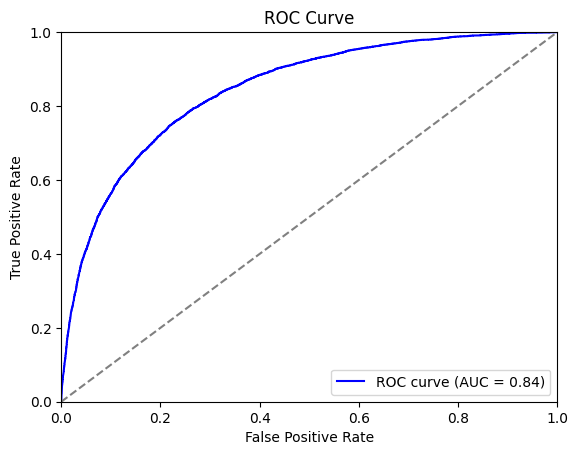

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, proba_test_smote, pos_label="Yes")
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auroc_smote:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [27]:
threshold = 0.6
pred_test_smote_2 = ['Yes' if (x>threshold) else 'No' for x in proba_test_smote]
print(classification_report(y_test, pred_test_smote_2, digits=4))

              precision    recall  f1-score   support

          No     0.8854    0.8852    0.8853     21918
         Yes     0.5971    0.5974    0.5972      6240

    accuracy                         0.8214     28158
   macro avg     0.7412    0.7413    0.7413     28158
weighted avg     0.8215    0.8214    0.8215     28158



In [28]:
from xgboost import XGBClassifier

In [34]:
y_train_bool = [1 if x == 'Yes' else 0 for x in y_train]
y_test_bool = [1 if x == 'Yes' else 0 for x in y_test]

In [65]:
xgb_clf = XGBClassifier(
    n_estimators = 10,
    max_depth = 3,
    device = 'cpu',
    verbosity = 2,
    eval_metric = 'auc', 
    colsample_bytree = 0.7,
    enable_categorical = False)

xgb_clf.fit(X_train, y_train_bool)
#pred_train_xgb = xgb_clf.predict(X_train)
#pred_test_xgb = xgb_clf.predict(X_test)

proba_train_xgb = xgb_clf.predict_proba(X_train)[:,1]
proba_test_xgb = xgb_clf.predict_proba(X_test)[:,1]

threshold = 0.3
pred_train_xgb = [1 if (x>threshold) else 0 for x in proba_train_xgb]
pred_test_xgb = [1 if (x>threshold) else 0 for x in proba_test_xgb]

auroc_xgb_train = roc_auc_score(y_train_bool, proba_train_xgb)
auroc_xgb_test = roc_auc_score(y_test_bool, proba_test_xgb)
                                
print('Train---------------')
print(f'AUROC on train: {auroc_xgb_train:.6f}')
print(classification_report(y_train_bool, pred_train_xgb, digits=4))
print('Test----------------')
print(f'AUROC on test: {auroc_xgb_test:.6f}')
print(classification_report(y_test_bool, pred_test_xgb, digits=4))


Train---------------
AUROC on train: 0.862444
              precision    recall  f1-score   support

           0     0.9015    0.8701    0.8855     87668
           1     0.5934    0.6661    0.6277     24961

    accuracy                         0.8249    112629
   macro avg     0.7475    0.7681    0.7566    112629
weighted avg     0.8332    0.8249    0.8284    112629

Test----------------
AUROC on test: 0.860984
              precision    recall  f1-score   support

           0     0.9035    0.8684    0.8856     21918
           1     0.5933    0.6744    0.6312      6240

    accuracy                         0.8254     28158
   macro avg     0.7484    0.7714    0.7584     28158
weighted avg     0.8348    0.8254    0.8292     28158



In [53]:
!pip install hyperopt

     ---------------------------------------- 0.0/57.7 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.7 kB ? eta -:--:--
     -------------------- ----------------- 30.7/57.7 kB 445.2 kB/s eta 0:00:01
     --------------------------------- ---- 51.2/57.7 kB 525.1 kB/s eta 0:00:01
     -------------------------------------- 57.7/57.7 kB 435.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.6 MB 2.9 MB/s eta 0:00:01
   ------- -------------------------------- 0.3/1.6 MB 3.5 MB/s eta 0:00:01
   ------------- -------------------------- 0.5/1.6 MB 4.7 MB/s eta 0:00:01
   -------------------------- ------------- 1.0/1.6 MB 6.5 MB/s eta 0:00:01
   -------------------------------------- - 1.5/1.6 MB 7.5 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 6.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ----------- ------


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [59]:
!pip install setuptools

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.2 MB 330.3 kB/s eta 0:00:04
   - -------------------------------------- 0.0/1.2 MB 330.3 kB/s eta 0:00:04
   ---- ----------------------------------- 0.1/1.2 MB 950.9 kB/s eta 0:00:02
   ---------- ----------------------------- 0.3/1.2 MB 1.8 MB/s eta 0:00:01
   ----------------- ---------------------- 0.5/1.2 MB 2.4 MB/s eta 0:00:01
   --------------------------------- ------ 1.0/1.2 MB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 4.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [63]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
# Save model with new trained estimator
rf_model = {
    'model': model_components['model'],
    'imputer': model_components['imputer'],
    'scaler': model_components['scaler'],
    'encoder': model_components['encoder'],
    'input_cols': model_components['input_cols'],
    'target_col': model_components['target_col'],
    'numeric_cols': model_components['numeric_cols'],
    'categorical_cols': model_components['categorical_cols'],
    'encoded_cols': model_components['encoded_cols']
}
joblib.dump(rf_model, "models/rf_model.joblib")